In [2]:
from sklearn import tree
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
import math as m
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [4]:
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Представляет собой прототип системы поиска, классификации и визуализация аномалий в информации между базами вылова и переработки рыбопродуктов внутри РФ с выводом результатов в машиночитаемом и человекочитаемом виде.

Технический эксперт оценивает решение
по следующим критериям:
1. Запускаемость кода
2. Обоснованность выбранного метода (описание подходов к решению,
их обоснование и релевантность задаче)
3. Точность работы алгоритма (возможность оценить формальной
метрикой с обоснованием выбора)
4. Адаптивность/Масштабируемость
5. Отсутствие в решении импортного ПО и библиотек, кроме свободно
распространяемого с обоснованием выбора
6. Наличие интеграционных интерфейсов, в первую очередь
интерфейсов загрузки данных

Отраслевой эксперт и/или представитель
Кейсодержателя оценивает решение
по следующим критериямм:
1. Релевантность поставленной задаче (команда погрузилась в отрасль,
проблематику; предложенное решение соответствует поставленной
задаче; проблема и решение структурированы)
2. Уровень реализации (концепция/прототип и тд)
3.Проработка пользовательских историй (UX/UI)
4. Реализация в решении требований Заказчика Вывод результатов
в машиночитаемом и человекочитаемом виде
5. Выступление команды (умение презентовать результаты своей
работы, строить логичный, понятный и интересный рассказ
для презентации результатов своей работы)

1) catch и product слить в одну бд, и ext1 и 2 -что такое prod vol и broad vol чем отличаются

2) построить графики зависимости - по оси даты, какой корабль приносит какой тип рыбы - или сразу ищем кластеризацией, kmeans например

3) Посмотреть как вариант PCA + The Mahalanobis distance is widely used in cluster analysis and classification techniques. In order to use the Mahalanobis distance to classify a test point as belonging to one of N classes, one first estimates the covariance matrix of each class, usually based on samples known to belong to each class. In our case, as we are only interested in classifying “normal” vs “anomaly”, we use training data that only contains normal operating conditions to calculate the covariance matrix. Then, given a test sample, we compute the Mahalanobis distance to the “normal” class, and classifies the test point as an “anomaly” if the distance is above a certain threshold

In [6]:
catch = pd.read_csv("db1/catch.csv")

Данные по выловленной рыбе - 
регион, тип рыбы, объем улова, режим вылова, разрешение, номер собственника

In [39]:
catch

,id_ves,date,id_region,id_fish,catch_volume,id_regime,permit,id_own
0,4524386,2022-01-01,272,400,32,41,852296,7115834
1,474886,2022-01-01,277,886,0,1,5401178,1809581
2,3160994,2022-01-01,116,409,26,15,3869431,5258490
3,1234400,2022-01-01,272,292,10,1,2169057,1809581
4,1234400,2022-01-01,272,113,0,1,2169057,1809581
...,...,...,...,...,...,...,...,...
85082,4992471,2022-04-20,108,410,1,18,1518104,8379463
85083,7645033,2022-04-20,265,292,1,97,1750243,1002633
85084,5951077,2022-04-20,507,113,0,97,5099847,440996
85085,5292474,2022-04-20,206,147,1,97,229919,7829965


In [8]:
product = pd.read_csv("db1/product.csv")

Данные по выловленной рыбе - 

In [38]:
product

,id_ves,date,id_prod_designate,id_prod_type,prod_volume,prod_board_volume
0,1491364,2022-01-01,1,10128,0,8
1,7014122,2022-01-01,3,3901,0,43
2,8958321,2022-01-01,1,1113,0,0
3,8958321,2022-01-01,1,1135,0,4
4,8958321,2022-01-01,1,4648,0,0
...,...,...,...,...,...,...
395066,3156205,2022-04-20,1,1027,0,0
395067,3156205,2022-04-20,1,1055,0,0
395068,2467785,2022-04-20,1,9661,0,6
395069,2467785,2022-04-20,1,9660,9,72


In [56]:
ext1 = pd.read_csv("db2/Ext.csv")
ext2 = pd.read_csv("db2/Ext2.csv")
print(ext1.shape[0], ext2.shape[0])

3260798 3115280


Данные по продаже - тип рыбы, номер владельца, дата, что-то ненужное, айди платформы (юрлица), уникальный серийник записи - "ключ", "имя" юрлица, дата/период, регион

In [11]:
ext1.head(5)

,id_fishery,id_own,date_fishery,numPart,id_Plat,id_vsd,Name_Plat,Product_period,Region_Plat
0,2208303,6493928,2022-05-24 00:00:00,\N,5022636,8745666,\N,\N,\N
1,5538439,3846064,2022-05-24 00:00:00,\N,839830,3846313,\N,\N,\N
2,8688535,3107158,2022-05-24 00:00:00,\N,9310751,5215676,\N,\N,\N
3,8688535,3107158,2022-05-24 00:00:00,\N,9310751,4008716,\N,\N,\N
4,9102536,6493928,2022-05-24 00:00:00,\N,2900344,8522784,\N,\N,\N


уникальный серийник записи - "ключ", номер сертификата вариант Б , номер рыбы, текстом рыба, дата объем единицы

In [12]:
ext2.head(5)

,id_vsd,num_vsd,id_fish,fish,date_vsd,volume,unit
0,7230988,8934601,400,минтай,2022-01-01 00:39:56,75480,\N
1,3420538,1439843,400,минтай,2022-01-01 01:34:08,62586,\N
2,9509257,342637,292,треска,2022-01-01 01:34:11,1155,\N
3,1894307,1801854,400,минтай,2022-01-01 01:34:05,111048,\N
4,9410489,3126516,88,окунь-клювач,2022-01-01 01:34:11,1844,\N


In [51]:
catch_product = pd.merge(catch, product, how="outer", on=['id_ves','date'])

In [52]:
catch_product.shape

(1043213, 12)

In [53]:
catch_product

,id_ves,date,id_region,id_fish,catch_volume,id_regime,permit,id_own,id_prod_designate,id_prod_type,prod_volume,prod_board_volume
0,4524386,2022-01-01,272,400,32,41,852296,7115834,1,3964,0,4
1,4524386,2022-01-01,272,400,32,41,852296,7115834,1,3524,18,352
2,4524386,2022-01-01,272,400,32,41,852296,7115834,1,2606,2,29
3,4524386,2022-01-01,272,400,32,41,852296,7115834,1,2472,0,10
4,474886,2022-01-01,277,886,0,1,5401178,1809581,4,4555,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1043208,2937153,2022-04-20,NaN,NaN,NaN,NaN,NaN,NaN,3,9373,0,1
1043209,2937153,2022-04-20,NaN,NaN,NaN,NaN,NaN,NaN,3,9374,0,1
1043210,2937153,2022-04-20,NaN,NaN,NaN,NaN,NaN,NaN,3,9451,0,1
1043211,3156205,2022-04-20,NaN,NaN,NaN,NaN,NaN,NaN,1,1027,0,0


In [15]:
sorted_cp = catch_product.sort_values(by=['prod_board_volume'],ascending=False)
sorted_cp.head(300)

,id_ves,date,id_region,id_fish,catch_volume,id_regime,permit,id_own,id_prod_designate,id_prod_type,prod_volume,prod_board_volume
1001934,8697712,2022-03-21,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4555.0,0.000000,9618.797271
997952,8697712,2022-03-19,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4555.0,0.000000,9618.797271
993454,8697712,2022-03-16,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4555.0,0.000000,9618.797271
996256,8697712,2022-03-18,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4555.0,0.000000,9618.797271
1005617,8697712,2022-03-23,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4555.0,0.000000,9618.797271
999689,8697712,2022-03-20,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4555.0,0.000000,9618.797271
994840,8697712,2022-03-17,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4555.0,0.000000,9618.797271
1004165,8697712,2022-03-22,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4555.0,0.000000,9618.797271
1029028,8697712,2022-04-10,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4555.0,0.000000,9618.782271
1019886,8697712,2022-04-03,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4555.0,0.000000,9618.782271


In [16]:
catch_product['catch_volume'] = catch_product['catch_volume'].apply(lambda x: x*1000)

In [17]:
catch_product.head(6)

,id_ves,date,id_region,id_fish,catch_volume,id_regime,permit,id_own,id_prod_designate,id_prod_type,prod_volume,prod_board_volume
0,4524386,2022-01-01,272.0,400.0,31874.0,41.0,852296.0,7115834.0,1.0,3964.0,0.161,4.485
1,4524386,2022-01-01,272.0,400.0,31874.0,41.0,852296.0,7115834.0,1.0,3524.0,18.172,352.446
2,4524386,2022-01-01,272.0,400.0,31874.0,41.0,852296.0,7115834.0,1.0,2606.0,1.785,29.438
3,4524386,2022-01-01,272.0,400.0,31874.0,41.0,852296.0,7115834.0,1.0,2472.0,0.437,9.798
4,474886,2022-01-01,277.0,886.0,476.0,1.0,5401178.0,1809581.0,4.0,4555.0,0.000,1.080
5,474886,2022-01-01,277.0,886.0,476.0,1.0,5401178.0,1809581.0,4.0,3757.0,0.000,3.800


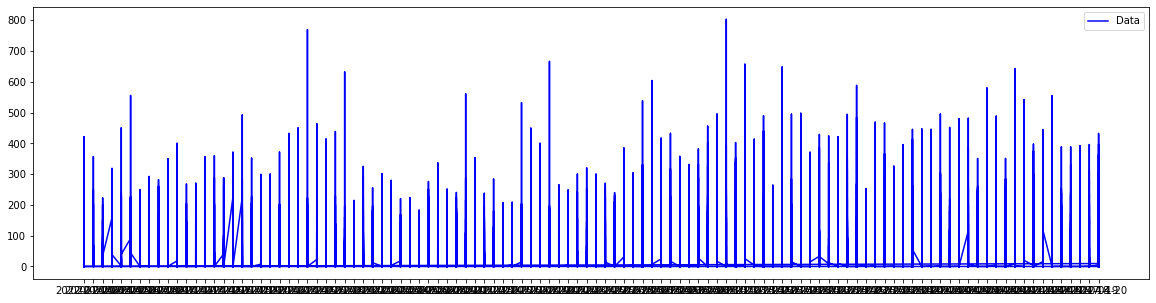

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(catch_product['date'], catch_product['prod_volume'], color='blue', label='Data')
plt.legend()

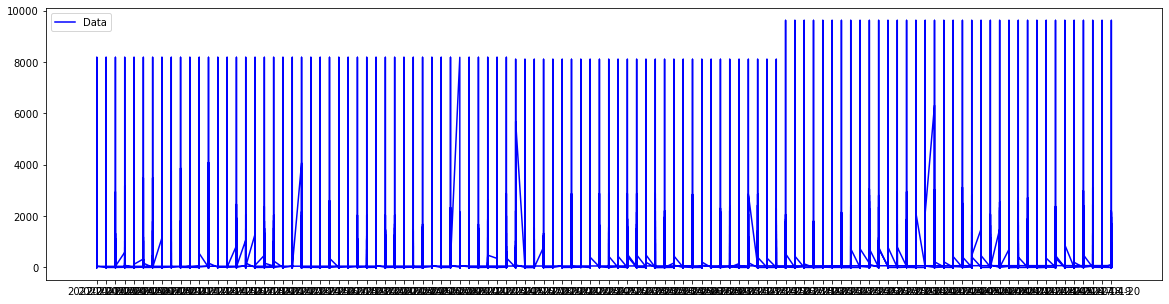

In [20]:
plt.figure(figsize=(20, 5))
plt.plot(catch_product['date'], catch_product['prod_board_volume'], color='blue', label='Data')
plt.legend()

In [21]:
catch_product.shape

(1043213, 12)

In [22]:
ext1_2 = pd.merge(ext1, ext2, how="outer", on=['id_vsd'])

In [54]:
ext1_2.shape

(3353908, 17)

In [23]:
ext1_2.head(5)

,id_fishery,id_own,date_fishery,numPart,id_Plat,id_vsd,Name_Plat,Product_period,Region_Plat,num_vsd,id_fish,fish,date_vsd,volume,unit
0,2208303.0,6493928.0,2022-05-24 00:00:00,\N,5022636.0,8745666,\N,\N,\N,5082710.0,292.0,треска,2022-05-24 17:31:35,17522.0,\N
1,5538439.0,3846064.0,2022-05-24 00:00:00,\N,839830.0,3846313,\N,\N,\N,213740.0,400.0,минтай,2022-05-24 17:31:35,72665.0,\N
2,8688535.0,3107158.0,2022-05-24 00:00:00,\N,9310751.0,5215676,\N,\N,\N,4867595.0,292.0,треска,2022-05-24 20:40:39,5250.0,\N
3,8688535.0,3107158.0,2022-05-24 00:00:00,\N,9310751.0,4008716,\N,\N,\N,6447636.0,112.0,палтус белокорый,2022-05-24 20:40:38,243.0,\N
4,9102536.0,6493928.0,2022-05-24 00:00:00,\N,2900344.0,8522784,\N,\N,\N,2275088.0,292.0,треска,2022-05-24 22:43:36,18536.0,\N


In [44]:
pd.options.display.float_format = '{:.0f}'.format

In [45]:
ext1_2['date'] = pd.to_datetime(ext1_2['date_fishery']).dt.date
ext1_2['time_fishery'] = pd.to_datetime(ext1_2['date_fishery']).dt.time

In [46]:
#ext1_2_wona = ext1_2.dropna(subset = ['id_fishery'],inplace=True)
ext1_2_wona = ext1_2.replace(to_replace='None', value=np.nan).dropna()

In [47]:
ext1_2_wona

,id_fishery,id_own,date_fishery,numPart,id_Plat,id_vsd,Name_Plat,Product_period,Region_Plat,num_vsd,id_fish,fish,date_vsd,volume,unit,date,time_fishery
0,2208303,6493928,2022-05-24 00:00:00,\N,5022636,8745666,\N,\N,\N,5082710,292,треска,2022-05-24 17:31:35,17522,\N,2022-05-24,00:00:00
1,5538439,3846064,2022-05-24 00:00:00,\N,839830,3846313,\N,\N,\N,213740,400,минтай,2022-05-24 17:31:35,72665,\N,2022-05-24,00:00:00
2,8688535,3107158,2022-05-24 00:00:00,\N,9310751,5215676,\N,\N,\N,4867595,292,треска,2022-05-24 20:40:39,5250,\N,2022-05-24,00:00:00
3,8688535,3107158,2022-05-24 00:00:00,\N,9310751,4008716,\N,\N,\N,6447636,112,палтус белокорый,2022-05-24 20:40:38,243,\N,2022-05-24,00:00:00
4,9102536,6493928,2022-05-24 00:00:00,\N,2900344,8522784,\N,\N,\N,2275088,292,треска,2022-05-24 22:43:36,18536,\N,2022-05-24,00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205598,2337731,8205073,2021-12-31 00:00:00,\N,2352176,3671444,\N,\N,\N,4096043,292,треска,2022-01-01 15:26:58,15911,\N,2021-12-31,00:00:00
3205599,2337731,8205073,2021-12-31 00:00:00,\N,2352176,4815350,\N,\N,\N,8272597,408,пикша,2022-01-01 15:26:58,10446,\N,2021-12-31,00:00:00
3205600,2337731,8205073,2021-12-31 00:00:00,\N,2352176,8678319,\N,\N,\N,4023560,610,зубатка синяя,2022-01-01 15:26:59,1228,\N,2021-12-31,00:00:00
3205601,2337731,8205073,2021-12-31 00:00:00,\N,2352176,5798588,\N,\N,\N,7108619,714,камбала-ерш,2022-01-01 15:26:59,188,\N,2021-12-31,00:00:00


# Сравниваем, что судно есть и там, и там

In [58]:
catch_product['id_own'].isin(ext1_2['id_own']).value_counts() #владельцы

True     856339
False    186874
Name: id_own, dtype: int64

In [59]:
ext1_2['id_own'].isin(catch_product['id_own']).value_counts()

False    3106092
True      247816
Name: id_own, dtype: int64

In [63]:
catch_product['id_ves'].isin(ext1_2_wona['id_fishery']).value_counts() #суда

False    1043213
Name: id_ves, dtype: int64

In [30]:
ext1_2_wona['id_fishery'] = ext1_2_wona['id_fishery'].astype(int)

In [31]:
result = ext1_2.dtypes
result

id_fishery        float64
id_own            float64
date_fishery       object
numPart            object
id_Plat           float64
id_vsd              int64
Name_Plat          object
Product_period     object
Region_Plat        object
num_vsd           float64
id_fish           float64
fish               object
date_vsd           object
volume            float64
unit               object
date               object
time_fishery       object
dtype: object

In [64]:
ext1_2['id_fishery'].isnull().sum()

1402

In [65]:
print(ext1_2['id_fishery'].unique())

[ 2.208303e+06  5.538439e+06  8.688535e+06  9.102536e+06  2.219706e+06
  1.409554e+06  7.412083e+06  6.084830e+05  4.128905e+06  2.769750e+06
  5.868605e+06  7.362125e+06  3.022928e+06  4.140694e+06  8.691140e+06
  4.853156e+06  4.312726e+06  7.164214e+06  5.536392e+06  8.519237e+06
  7.943780e+06  8.938434e+06  8.548850e+06  9.301657e+06  1.069273e+06
  2.375353e+06  3.068810e+06  1.271379e+06  9.052033e+06  8.673678e+06
  3.911925e+06  1.453676e+06  8.876016e+06  7.432644e+06  6.791380e+06
  8.883685e+06  1.285124e+06  9.128921e+06  6.350471e+06  8.573165e+06
  3.949342e+06  1.988706e+06  8.076334e+06  6.591042e+06  9.380862e+06
  5.006810e+06  2.946436e+06  6.968933e+06  7.828253e+06  3.329500e+04
  4.800458e+06  1.030269e+06  3.593858e+06  1.010430e+05  2.811150e+06
  4.487588e+06  1.306716e+06  7.483362e+06  4.761827e+06  5.872996e+06
  2.634670e+06  6.169671e+06  2.402426e+06  4.880073e+06  6.607712e+06
  5.019158e+06  5.978123e+06  8.774611e+06  1.190952e+06  5.457324e+06
  4.91

# Сравним объемы хотя бы

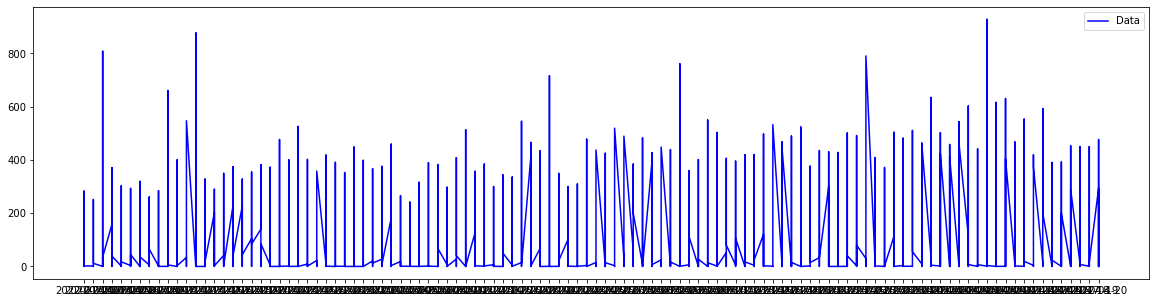

In [66]:
plt.figure(figsize=(20, 5))
plt.plot(catch_product['date'], catch_product['catch_volume'], color='blue', label='Data')
plt.legend()

ConversionError: Failed to convert value(s) to axis units: array([datetime.date(2022, 5, 24), datetime.date(2022, 5, 24),
       datetime.date(2022, 5, 24), ..., NaT, NaT, NaT], dtype=object)

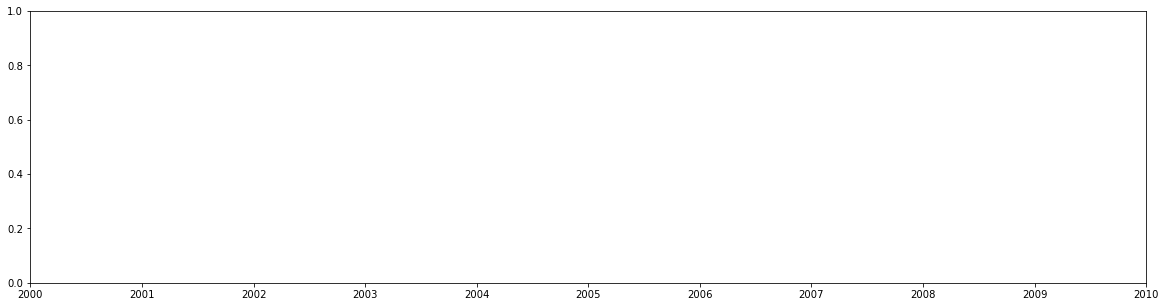

In [67]:
plt.figure(figsize=(20, 5))
plt.plot(ext1_2['date'], ext1_2['volume'], color='blue', label='Data')
plt.legend()

In [68]:
ext12_sorted = ext1_2.sort_values(by=['volume'],ascending=False)
ext12_sorted.head(10)

,id_fishery,id_own,date_fishery,numPart,id_Plat,id_vsd,Name_Plat,Product_period,Region_Plat,num_vsd,id_fish,fish,date_vsd,volume,unit,date,time_fishery
97994,-1,5502023,2022-04-18 02:07:09,\N,657606,4907685,5556653,\N,Камчатский край,2368455,-1,сельдь тихоокеанская н/р мороженая,2022-04-18 02:07:09,39620000,кг,2022-04-18,02:07:09
2059325,576360,9290322,2022-02-11 00:00:00,\N,2345556,8564557,\N,\N,\N,6046821,292,треска,2022-02-11 23:09:41,3905000,\N,2022-02-11,00:00:00
2059323,-1,5502023,2022-02-11 23:09:41,\N,2345556,8564557,5587239,2022-02-11 00:00:00,Сахалинская область,6046821,292,треска,2022-02-11 23:09:41,3905000,\N,2022-02-11,23:09:41
1251785,-1,5502023,2022-03-10 09:18:02,\N,6452785,6671469,9428728,2022-02-23 00:00:00 - 2022-03-08 00:00:00,Мурманская область,1722957,-1,мойва,2022-03-10 09:18:02,3222382,кг,2022-03-10,09:18:02
1171113,-1,5502023,2022-03-13 12:52:18,\N,5716924,3694722,6930294,2022-02-21 00:00:00 - 2022-03-06 00:00:00,Мурманская область,518703,-1,мойва мороженая,2022-03-13 12:52:18,2850705,кг,2022-03-13,12:52:18
1250236,-1,5502023,2022-03-10 09:41:38,\N,6452785,4484587,9428728,2022-02-23 00:00:00 - 2022-03-08 00:00:00,Мурманская область,2934914,-1,мойва мороженая,2022-03-10 09:41:38,2716584,кг,2022-03-10,09:41:38
2580992,-1,5502023,2022-01-26 09:13:20,\N,4390694,2434417,4472866,2022-01-12 00:00:00 - 2022-01-21 00:00:00,Камчатский край,4306164,-1,скумбрия мороженая,2022-01-26 09:13:20,2309096,кг,2022-01-26,09:13:20
2610711,-1,5502023,2022-01-25 10:44:16,\N,2603955,2716226,8206639,2022-01-11 00:00:00 - 2022-01-24 00:00:00,Камчатский край,6037624,-1,минтай мороженый,2022-01-25 10:44:16,2277329,кг,2022-01-25,10:44:16
1423761,-1,5502023,2022-03-04 07:32:26,\N,7814957,3371508,3142981,2022-01-17 00:00:00 - 2022-02-24 00:00:00,Приморский край,5365592,-1,минтай,2022-03-04 07:32:26,2254469,кг,2022-03-04,07:32:26
1094252,-1,5502023,2022-03-15 17:41:37,\N,9394691,4129979,7550205,2022-02-22 00:00:00 - 2022-03-10 00:00:00,Мурманская область,8212976,-1,путассу н/р мороженая,2022-03-15 17:41:37,2244000,кг,2022-03-15,17:41:37


# Сгруппируем по типу рыбы, посмотрим что и как 

In [119]:
fish_numbers = pd.read_csv('db1/ref/fish.csv', sep=';')

In [196]:
fish_id_new = fish_numbers.id_fish.unique()

In [197]:
fish_id_new

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,   591,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    45,    53,    59,    60,    62,    65,
          71,    72,    88,    90,    96,   100,   101,   102,   104,
         105,   107,   108,   109,   110,   111,   112,   113,   114,
         128,   144,   145,   156,   157,   166,   184,   203,   205,
         210,   221,   224,   228,   229,   233,   247,   249,   251,
         252,   253,   254,   256,   265,   280,   285,   286,   288,
         290,   292,   294,   302,   303,   318,   321,   341,   346,
         354,   359,   365,   371,   375,   377,   389,   394,   399,
         400,   401,   403,   408,   410,   411,   412,   419,   431,
         434,   438,   444,   469,   477,   493,   512,   514,   524,
         537,   540,

In [231]:
new_df = pd.DataFrame(columns = ['fish_id', 'fish', 'catch_volume', 'rec_volume', 'id_own'])


for fish in fish_id_new:
    if catch_product.loc[catch_product['id_fish'] == fish].catch_volume.sum()*1000  <  ext1_2.loc[ext1_2['id_fish'] == fish].volume.sum():
        new_df = new_df.append({'fish_id': fish, 
                                'fish': fish_numbers.loc[fish_numbers['id_fish'] == fish].fish.to_list()[0], 
                                'catch_volume': catch_product.loc[catch_product['id_fish'] == fish].catch_volume.sum()*1000,
                                'rec_volume':ext1_2.loc[ext1_2['id_fish'] == fish].volume.sum(),
                               'id_own': ext1_2.loc[ext1_2['id_fish'] == fish].id_own.to_list()}, ignore_index=True)
 

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/136803597.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/136803597.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/136803597.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/136803597.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

In [232]:
new_df

,fish_id,fish,catch_volume,rec_volume,id_own
0,45,аргентина,0,1203,"[7024329.0, 7024329.0, 7024329.0, 7024329.0, 7..."
1,71,треска ярусная,0,45780,"[7829965.0, 2043828.0]"
2,302,корюшка,0,66,"[5502023.0, 9290322.0]"
3,512,ставрида,0,50310,"[7656004.0, 7656004.0]"
4,639,кукумария,1040,239392,"[8768128.0, 6462295.0, 6462295.0, 6462295.0, 6..."
5,760,лемонема,41115,1152870,"[5502023.0, 9290322.0, 5502023.0, 9290322.0, 5..."
6,863,креветка гренландская,0,1414,[4111289.0]
7,927,трубачи,57183,222499,"[794477.0, 794477.0, 794477.0, 6462295.0, 7944..."
8,885,петух морской,0,644,"[7024329.0, 7024329.0]"
9,91,удильщик (морской черт),704,1361,"[7024329.0, 7024329.0, 7024329.0]"


In [222]:
id_own = new_df.id_own.to_list()

In [224]:
flat_id_own = [item for sublist in id_own for item in sublist]

In [228]:
flat_id_own = sorted(flat_id_own)

duplicates_own =[]
for i in flat_id_own:
     if flat_id_own.count(i)>1:
         if i not in duplicates_own:
             duplicates_own.append(int(i))
 
print(duplicates_own)

[78422, 794477, 1778753, 2369769, 2567272, 5258490, 5502023, 6462295, 7024329, 7115834, 7284807, 7656004, 7708239, 8414959, 8520001, 8768128, 9290322]


Прям разница между объемами 


In [250]:
new_df = pd.DataFrame(columns = ['fish_id', 'fish', 'catch_volume', 'rec_volume',   'id_own'])


for fish in fish_id_new:
        new_df = new_df.append({'fish_id': fish, 
                                'fish': fish_numbers.loc[fish_numbers['id_fish'] == fish].fish.to_list()[0], 
                                'catch_volume': catch_product.loc[catch_product['id_fish'] == fish].catch_volume.sum()*1000,
                                'rec_volume':ext1_2.loc[ext1_2['id_fish'] == fish].volume.sum(),
                                'id_own': ext1_2.loc[ext1_2['id_fish'] == fish].id_own.to_list()}, ignore_index=True)
 

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append({'fish_id': fish,
/var/folders/qm/4msvsbgs0cv0140pwhdz8xww0000gn/T/ipykernel_1225/897552251.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.a

In [256]:
new_df = new_df[(new_df['catch_volume']> 0) | (new_df['rec_volume'] > 0)]

In [278]:
new_df['volume_ratio'] = new_df['rec_volume']/(new_df['catch_volume']) 

In [279]:
new_df

,fish_id,fish,catch_volume,rec_volume,id_own,volume_ratio
6,6,шпрот (килька),1856600,1362130,"[8608103.0, 8608103.0, 8608103.0, 8608103.0, 8...",1
17,591,прочие морские рыбы,561,0,[],0
39,45,аргентина,0,1203,"[7024329.0, 7024329.0, 7024329.0, 7024329.0, 7...",inf
45,71,треска ярусная,0,45780,"[7829965.0, 2043828.0]",inf
47,88,окунь-клювач,72177741,9885803,"[7656004.0, 6885089.0, 9405992.0, 4760527.0, 7...",0
48,90,зубан,552357,87777,"[7372847.0, 5258490.0, 5258490.0, 7372847.0, 5...",0
60,112,палтус белокорый,8423015,605687,"[3107158.0, 6493928.0, 9382283.0, 9382283.0, 9...",0
61,113,палтус черный,26210010,2931390,"[7656004.0, 4618514.0, 4760527.0, 1921181.0, 7...",0
62,114,палтус стрелозубый,716875,51975,"[1754744.0, 1754744.0, 1754744.0, 1754744.0, 9...",0
63,128,хамса черноморская,19734200,0,[],0


In [277]:
print(new_df.dtypes)

fish_id          object
fish             object
catch_volume    float64
rec_volume      float64
id_own           object
volume_ratio    float64
dtype: object


In [271]:
new_df['rec_volume'] = new_df['rec_volume'].astype(float)

In [273]:
new_df['catch_volume'] = new_df['catch_volume'].astype(float)